L. Drew Hill

CE263N - Problem3

## Short Report
I began by reading in and plotting the data across California. Looked reasonable, and so I moved on to visually examine the normality of the data with a histogram: quite normal. I then set about creating a python class for predicting, simulating, and visualizing Gaussian Process data from a set of training, test, and prediction-grid datasets. A user is prompted to input the training dataset, testing dataset, bandwidth, and simulation grid.

### Prediction 
My prediction class fits a Gaussian regression to a training data set (input), and calculates K, L, and Cov with Scikit-Learn. Covariance was chosen as the default covariance function of Gaussian process covariance. Bandwidth was chosen by cross validation (described below). Noise variance was covered by the Scikit-Learn module. Values of rainfall are predicted by applying the resulting Gaussian regression model to the test data coordinates set. The prediceted set was uploaded to Kaggle.

### Simulation
The simulation function of the class predicts rainfall at each point on the Xgrid provided to us. I am quite certain that this approach does not adequately address stochasticity, and instead captures primarily deterministic effects of latitude and longitude. But, as described below, I spent many hours trying to make a more stochastic approach work, and I believe my understanding of Linear Algebra may be holding me back from writing this code form the ground up.

### Visualization
My class also allows for the visualization of data. First, it allows  in a simple and well-labeled plot. More importantly for this problem set, it outputs a text file in XML format that allows the simulated data to be opened in and mapped to Google Earth via KML. An image of this is included in the zip file.

<img src="data/Overlay.png">

### Cross Validation
The bandwidth size was selected using cross-validation. The provided "training" data were randomly split up into an 85% (training) and 15% (testing) for cross validation of the bandwidth measure. Bandwidths between 0.001 and 1 at intervals of 0.001 were tested, and R2 was used as the optimization function-- the highest R2 was taken. Ultimately, a bandwidth of 0.036 (r2 = 0.597) was determined the best.

### Note on failed attempts at writing my own code from scratch
For this problem, I attempted to follow the guidelines in lecture-- producing means and covariance matrices for the training data and employing Cholesky transformations. I could not, for the life of me, get past the Cholesky transformation. All of my attempts demonstrated very little variation in the outcome (rainfall). I abandoned this effort after many hours of trying to get it straight.

### The Code

In [2]:
## Were I to need to import the class I created; 
## instead I recreate it in this text for the purposes of the report
#!/usr/bin/env python
# from GPthis_cv import GPthis_cv

from pylab import *
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy import spatial
from sklearn.gaussian_process import GaussianProcessRegressor
# from geopy.distance import great_circle
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split

np.random.seed(1)
%matplotlib inline  

In [3]:
# read data in

trn = pd.read_csv( '/Users/Lawson/Box Sync/Current Coursework/CE263 - Scalable Spatial Analytics/Assignments/Problem 3/data/trn_data.csv')
grid = pd.read_csv( '/Users/Lawson/Box Sync/Current Coursework/CE263 - Scalable Spatial Analytics/Assignments/Problem 3/data/grid.csv')
tst = pd.read_csv( '/Users/Lawson/Box Sync/Current Coursework/CE263 - Scalable Spatial Analytics/Assignments/Problem 3/data/tst_locations.csv')

trn_n = np.array(trn)
tst_n = np.array(tst)
grid_n = np.array(grid)

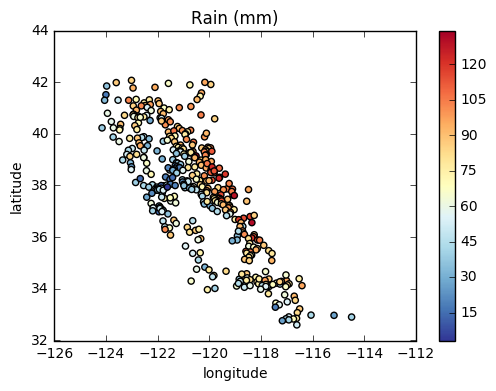

In [4]:
# plot the data in a Euclidian space to see what's up

# data and plot
fig, ax = subplots()
ax.scatter( x = trn.lon, y = trn.lat, c=trn.mm, cmap='RdYlBu_r')
ax.set_aspect(1)

#colors
scalarmappaple = cm.ScalarMappable(
    norm=mcolors.Normalize(vmin=trn.mm.min(), vmax=trn.mm.max()),
    cmap='RdYlBu_r')
scalarmappaple.set_array(trn.mm)
plt.colorbar(scalarmappaple)

# labels
xlabel('longitude')
ylabel('latitude')
title('Rain (mm)');

(array([  6.,  24.,  52.,  48.,  54.,  71.,  81.,  53.,  18.,   7.]),
 array([   3.1693 ,   16.27737,   29.38544,   42.49351,   55.60158,
          68.70965,   81.81772,   94.92579,  108.03386,  121.14193,  134.25   ]),
 <a list of 10 Patch objects>)

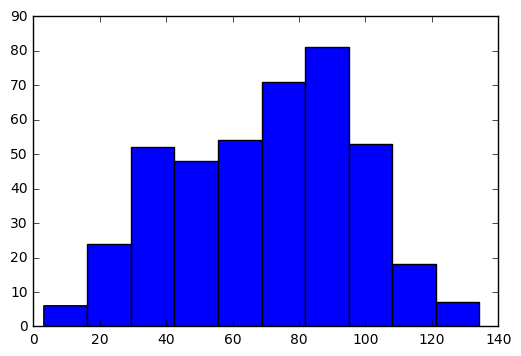

In [118]:
# examine normality
# fairly normal
plt.hist(trn.mm)

#### Define classes and relevant functions

In [6]:
# make rectangular grid with ncell nodes at each dimension
def make_grid(bounding_box, ncell):
    xmax, xmin, ymax, ymin = bounding_box 
    xgrid = np.linspace(xmin, xmax, ncell) 
    ygrid = np.linspace(ymin, ymax, ncell)
    
    mX, mY = np.meshgrid(xgrid, ygrid) 
    ngridX = mX.reshape(ncell*ncell, 1); 
    ngridY = mY.reshape(ncell*ncell, 1);
    
    return np.concatenate((ngridX, ngridY), axis=1)

In [7]:
# make 2500-point grid for prediction (the points upon which we'll predict rain)
bounding_box = [38.3, 39.3, -120.0, -121.0]
Xgrid = make_grid(bounding_box, 50)

# fig, ax = subplots()
# ax.scatter(Xgrid[:,0],Xgrid[:,1])
# plt.show()

In [116]:
class GPthis_CV:
    
    def __init__(self, train, test, bw, simulation_grid):
        self.train = np.array(train)
        self.test = np.array(test)
        self.grid = np.array(Xgrid)
        self.mu = np.mean(self.train[:,[2]])
        self.sigma = np.std(self.train[:,[2]])
        self.bw = bw
        
        # instanstanciate gp process, and gp fit
        self.gp = GaussianProcessRegressor(alpha = bw, normalize_y = True)
        self.gpfit = self.gp.fit(self.train[:,[0,1]],self.train[:,[2]])
        
        # produce K (covariance) and L (cholesky decomposition)
        self.K_test = self.gpfit.predict(self.test[:,[0,1]], return_cov=True)[1]
        self.L_test = np.linalg.cholesky(self.K_test + .001*np.eye(self.K_test.shape[0]))
        self.K_train = self.gpfit.predict(self.train[:,[0,1]], return_cov=True)[1]
        self.L_train = np.linalg.cholesky(self.K_train + .001*np.eye(self.K_train.shape[0]))
        
        # random single-fold cross-validating
        self.train_train, self.train_test = train_test_split(train, test_size = 0.15, random_state =0)
        self.gp_cv = GaussianProcessRegressor(alpha = bw, normalize_y = True)
        self.gpfit_cv = self.gp.fit(self.train_train[:,[0,1]],self.train_train[:,[2]])
        self.cv_score = self.gpfit_cv.score(self.train_test[:,[0,1]], self.train_test[:,[2]])
        
    def predict(self):
        self.pred = self.gpfit.predict(self.test[:,[0,1]])
        return self.pred
    
    def predicted_cov(self):
        self.cov_matrix = self.gpfit.predict(self.test[:,[0,1]], return_cov=True)[1]
        return self.cov_matrix
    
    def pred_score(self):
        self.score = self.gpfit.score(self.train[:,[0,1]], self.train[:,[2]])
        return self.score
    
    def simulate(self,N):
        return self.sigma*np.random.normal(0,1,N) + self.mu
    
    def grid_pred(self):
        self.K_pg = self.gpfit.predict(self.grid, return_cov=True)[1]
        self.L_pg = np.linalg.cholesky(self.K_pg + .001*np.eye(self.K_pg.shape[0]))
        
        # Predict using prediction algorithm SciKit
        self.sim1 = self.gpfit.predict(self.grid)
        # Predict using formulat from Problemset
#         self.sim1 = self.mu + self.L_pg
    
        self.sim_grid = np.concatenate((self.grid,self.sim1),axis=1)
        return self.sim_grid
    
    def visualize_train(self, filename, show=False):
        plt.hist(self.train[:,[2]], facecolor='green', alpha=0.5)
        plt.title("Hist: $\mu=%.2f$, $\sigma=%.2f$" % (self.mu, self.sigma)) 
        plt.savefig(filename)
        if show: 
            plt.show()
            
    def visualize_sim(self, filename, N, show=False):
        x = self.simulate(N)
        pred = self.gpfit.predict(self.test[:,[0,1]])
        plt.hist(x, facecolor='green', alpha=0.5)
        plt.title("Hist: $\mu=%.2f$, $\sigma=%.2f$" % (mean(x), std(x))) 
        plt.savefig(filename)
        if show: 
            plt.show()
            
    def visualize_grid_pred(self):
        # redo grid simulation
        self.sim1 = self.gpfit.predict(self.grid)
        self.sim_grid = np.concatenate((self.grid,self.sim1),axis=1)
        
        # create plots
        fig, ax = subplots()
        ax.scatter( x = self.sim_grid[:,1], y = self.sim_grid[:,0], c=self.sim_grid[:,2], cmap='RdYlBu_r')
        ax.set_aspect(1)
        
        #colors
        scalarmappaple = cm.ScalarMappable(
            norm=mcolors.Normalize(vmin=self.sim_grid[:,2].min(), vmax=self.sim_grid[:,2].max()),
            cmap='RdYlBu_r')
        scalarmappaple.set_array(self.sim_grid[:,2])
        plt.colorbar(scalarmappaple)

        # labels
        xlabel('longitude')
        ylabel('latitude')
        title('Rain (mm)')
        savefig('data/sim.png', transparent=True);
        
    def kml_output(self):
        # redo grid simulation
        self.sim1 = self.gpfit.predict(self.grid)
        self.sim_grid = np.concatenate((self.grid,self.sim1),axis=1)
        
        # create plots
        fig, ax = subplots()
        ax.scatter( x = self.sim_grid[:,1], y = self.sim_grid[:,0], c=self.sim_grid[:,2], cmap='RdYlBu_r')
        ax.set_aspect(1)
        plt.axis('off')
        
        #colors
        scalarmappaple = cm.ScalarMappable(
            norm=mcolors.Normalize(vmin=self.sim_grid[:,2].min(), vmax=self.sim_grid[:,2].max()),
            cmap='RdYlBu_r')
        scalarmappaple.set_array(self.sim_grid[:,2])
        
        # remove white space around image
        subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
        margins(0,0)
        gca().xaxis.set_major_locator(NullLocator())
        gca().yaxis.set_major_locator(NullLocator())

        # save
        savefig('data/sim_noaxis.png', transparent=True, bbox_inches = 'tight', pad_inches= 0);
        
        ## Generate KML file
            # create and open file called overlay.kml
        text_file = open("data/overlay.kml","w")
            # write to that file
        text_file.write("""<?xml version="1.0" encoding="UTF-8"?>
        <kml xmlns="http://www.opengis.net/kml/2.2" xmlns:gx="http://www.google.com/kml/ext/2.2" xmlns:kml="http://www.opengis.net/kml/2.2" xmlns:atom="http://www.w3.org/2005/Atom">
        <GroundOverlay>
            <name>CE263N Problem3 overlay</name>
            <color>dbffffff</color>
            <Icon>
                <href>/Users/Lawson/Box Sync/Current Coursework/CE263 - Scalable Spatial Analytics/Assignments/Problem 3/data/sim_noaxis.png</href>
                <viewBoundScale>0.75</viewBoundScale>
            </Icon>
            <LatLonBox>
                <north>39.3</north>
                <south>38.3</south>
                <east>-120.0</east>
                <west>-121.0</west>
            </LatLonBox>
        </GroundOverlay>
        </kml>""")
            # close file
        text_file.close()

#### Cross Validation to find best bandwidth
Note: CV is not included in the Prediction class that I made, because it takes quite a long time to run. I didn't want to have to cross validate everytime I re-ran a routine that relied on the GP function.

In [117]:
## Loop to mathematically determine best bandwidth 
## using cross-validation (15% testing sample)
# create float range function (borrowed from StackExchange)
def frange(x, y, jump):
    while x < y:
        yield x
        x += jump

# create array
cv_bw = np.empty((0,2), float64)

# append to it
for i in frange(.001, 1, .001):
    a = GPthis_CV(trn_n, tst_n, i, Xgrid).cv_score
    b = np.array([[i,a]])
    cv_bw = np.append(cv_bw, b ,axis=0)

# print maximum (BW = .036, r2 = 0.59705836)
cv_bw[np.argmax(cv_bw[:,1])]

array([ 0.036     ,  0.59705836])

#### Predict rainfall for test data

In [115]:
test_output = GPthis_CV(trn_n, tst_n, 0.036, Xgrid).predict()
test_output = pd.DataFrame(test_output)
test_output.to_csv('/Users/Lawson/Box Sync/Current Coursework/CE263 - Scalable Spatial Analytics/Assignments/Problem 3/data/submission_hill1.csv',sep=',', header =['mm'], index=True)

#### Simulate grid values and plot graph

In [112]:
# Plot heatmap and save to file
# individual viewing
GPthis_CV(trn_n, tst_n, 0.036, Xgrid).visualize_grid_pred()
# For overlay
GPthis_CV(trn_n, tst_n, 0.036, Xgrid).kml_output()

#### Failed attempts

In [ ]:
# # calculate mean
# m = mean(trn_n[:,[2]])

# # calculate covariance, K
# K = []

# for i in range(0,len(trn_n)-1):
#     x = np.array([trn_n[i,2] - m])
#     x_prime = np.array([trn_n[i + 1,2] - m])
#     K = np.append(K, x * x_prime, axis =0)

# K_mean = mean(K)
# noise_var = std(K)


# ## Examine distribution

# from scipy.stats.kde import gaussian_kde

# kde = gaussian_kde( K )
# dist_space = linspace( min(K), max(K), 100 )
# plt.plot( dist_space, kde(dist_space) )

# def covariance(X, Z, h):
#     d = spatial.distance_matrix(X,Z) 
#     K = np.exp(-(d**2) / (2*h*h)) 
#     return K

# K = covariance(trn_n[:,[0]], trn_n[:,[1]], 0.01)

# L = np.linalg.cholesky(K + np.eye(K.shape[0]))